<a href="https://colab.research.google.com/github/boshuaiYu/CaiCai_sklearn/blob/main/Feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
data = pd.read_csv("/content/digit recognizor.csv")

In [ ]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X.shape # 维度表示特征的个数784

(42000, 784)

1. Filter过滤法

1.1 方差过滤

1.1.1 VarianceThreshold

In [ ]:
from sklearn.feature_selection import VarianceThreshold
X_var0 = VarianceThreshold().fit_transform(X) # 默认方差为0
X_var0.shape

(42000, 708)

如果希望留下一半的
特征，那可以设定一个让特征总数减半的方差阈值，只要找到特征方差的中位数，再将这个中位数作为参数
threshold的值输入就好了

In [ ]:
import numpy as np
X_fsvar = VarianceThreshold(np.median(X.var().values)).fit_transform(X)
X_fsvar.shape

(42000, 392)

1.1.2 方差过滤对模型的影响

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import cross_val_score
import numpy as np

x = data.iloc[:,1:]
y = data.iloc[:,0]

x_fsvar = VarianceThreshold(np.median(x.var().values)).fit_transform(x)

KNN方差过滤前

In [ ]:
import time
start = time.time()
print(cross_val_score(KNN(),x,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.965857142857143
time: 116.22311735153198


KNN方差过滤后

In [ ]:
start = time.time()
print(cross_val_score(KNN(),x_fsvar,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.966
time: 70.07048320770264


随机森林方差过滤前

In [ ]:
start = time.time()
print(cross_val_score(RFC(n_estimators=10, random_state=0),x,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.9373571428571429
time: 13.382856607437134


In [ ]:
start = time.time()
print(cross_val_score(RFC(n_estimators=100,random_state=0),x,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.9642142857142856
time: 130.34048414230347


随机森林方差过滤后

In [ ]:
start = time.time()
print(cross_val_score(RFC(n_estimators=10,random_state=0),x_fsvar,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.9390476190476191
time: 13.622154951095581


In [ ]:
start = time.time()
print(cross_val_score(RFC(n_estimators=100,random_state=0),x,y,cv=5).mean())
end = time.time()
print("time:",end-start)

0.9642142857142856
time: 125.35949611663818


过滤法的主要对象是：需要遍历特征或升维的算法们，而过滤法的主要目的是：在维持算法表现的前提下，帮助算法们降低计算成本

过滤法对随机森林无用，却对决策树有用

方差过滤对模型准确度影响未知

1.2 相关性过滤

1.2.1 卡方过滤

卡方过滤是专门针对离散型标签（即分类问题）的相关性过滤

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_fschi = SelectKBest(chi2,k=300).fit_transform(X_fsvar,y)
X_fschi.shape

(42000, 300)

In [ ]:
cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()

0.9344761904761905

1.2.1.1 采用学习曲线的方式，来查看K的选择值

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

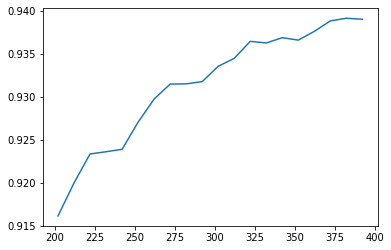

In [39]:
score = []
for i in range(392,200,-10):
  X_fschi = SelectKBest(chi2,k=i).fit_transform(X_fsvar,y)
  once = cross_val_score(RFC(n_estimators=10,random_state=0),X_fschi,y,cv=5).mean()
  score.append(once)
plt.plot(range(392,200,-10),score)

# 图线可以看出K值越大，准确率越高

1.2.1.2 看p值选择k

In [32]:
chivalue, pvalue = chi2(X_fsvar,y)

In [ ]:
chivalue

In [ ]:
pvalue

In [37]:
k = chivalue.shape[0] - (pvalue > 0.05).sum()
k
# 说明方差验证已经把所有相关的特征都找到，其他的都不能删去

392

1.3 F检验

F检验，又称ANOVA，方差齐性检验，是用来捕捉每个特征与标签之间的线性关系的过滤方法。它即可以做回归也可以做分类，因此包含feature_selection.f_classif（F检验分类）和feature_selection.f_regression（F检验回
归）两个类。其中F检验分类用于标签是离散型变量的数据，而F检验回归用于标签是连续型变量的数据

F检验在数据服从正态分布时效果会非常稳定，因此如果使用F检验过滤，我
们会先将数据转换成服从正态分布的方式

In [ ]:
from sklearn.feature_selection import f_classif
F, pvalue_f = f_classif(X_fsvar,y)
F

In [ ]:
pvalue_f

In [45]:
k = F.shape[0] - (pvalue_f > 0.5).sum()
k

392

有任何特征的p值大于0.01，所有的特征都是和标签相关的，因此我们不需要相关性过滤

1.4 互信息法

互信息法是用来捕捉每个特征与标签之间的任意关系（包括线性和非线性关系）的过滤方法

F检验只能找出线性关系，互信息法可以找出任意关系

In [47]:
from sklearn.feature_selection import mutual_info_classif as MIC
result = MIC(X_fsvar,y) # 互信息量的估计
result

array([0.06771637, 0.08341303, 0.09799794, 0.11126953, 0.11647567,
       0.1054957 , 0.08579308, 0.05438407, 0.07316761, 0.0974353 ,
       0.11907861, 0.14078727, 0.15730802, 0.16299848, 0.15105046,
       0.13442349, 0.09815152, 0.06873428, 0.02970268, 0.02548592,
       0.06616732, 0.10037206, 0.12349394, 0.15129768, 0.17957882,
       0.2023645 , 0.22105994, 0.23615708, 0.21504306, 0.18028193,
       0.13979229, 0.10364552, 0.07874879, 0.06184119, 0.05081043,
       0.03201645, 0.05574639, 0.07976284, 0.09953573, 0.12680214,
       0.13539502, 0.14847847, 0.15627722, 0.18463683, 0.18611228,
       0.17246709, 0.14259832, 0.12974507, 0.11081758, 0.09519889,
       0.0809205 , 0.07000381, 0.06414878, 0.04958213, 0.06631613,
       0.07160161, 0.08510387, 0.09364044, 0.10803886, 0.11179482,
       0.10793585, 0.11472754, 0.12381564, 0.11259784, 0.11184311,
       0.11902972, 0.11483882, 0.10789961, 0.09508306, 0.07902368,
       0.07021683, 0.03686784, 0.05271684, 0.06453979, 0.07325

In [48]:
k = result.shape[0] - sum(result<=0)
k

392

先使用方差过滤，然后使用互信息法来捕捉相关性

2. Embedded嵌入法

嵌入法是一种让算法自己决定使用哪些特征的方法，即特征选择和算法训练同时进行

In [49]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RandomForestClassifier

RFC_ = RFC(n_estimators=10,random_state=0) # 随机森林实例化
X_embedded = SelectFromModel(RFC_,threshold=0.005).fit_transform(X,y)
X_embedded.shape

(42000, 47)

使用学习曲线寻找最佳的threshold

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

RFC_.fit(X,y).feature_importances_

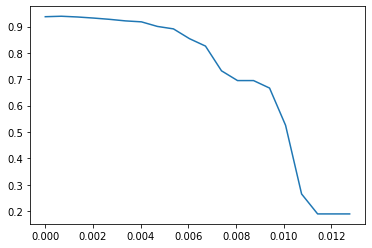

In [54]:
threshold = np.linspace(0,(RFC_.fit(X,y).feature_importances_).max(),20)
score = []
for i in threshold:
  X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
  once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
  score.append(once)

plt.plot(threshold,score)

In [55]:
X_embedded = SelectFromModel(RFC_,threshold=0.00067).fit_transform(X,y)
X_embedded.shape

(42000, 324)

In [56]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9391190476190475

([<matplotlib.axis.XTick at 0x7f8a2c7a26d0>,
 <a list of 30 Text major ticklabel objects>)

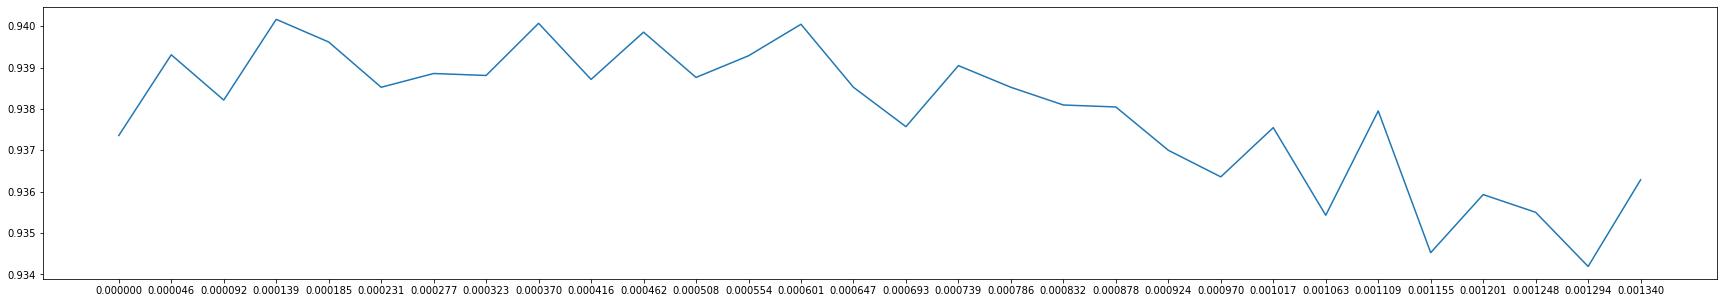

In [57]:
score2 = []
for i in np.linspace(0,0.00134,30):
  X_embedded = SelectFromModel(RFC_,threshold=i).fit_transform(X,y)
  once = cross_val_score(RFC_,X_embedded,y,cv=5).mean()
  score2.append(once)
plt.figure(figsize=[30,5])
plt.plot(np.linspace(0,0.00134,30),score2)
plt.xticks(np.linspace(0,0.00134,30))

In [58]:
X_embedded = SelectFromModel(RFC_,threshold=0.000139).fit_transform(X,y)
X_embedded.shape

(42000, 428)

In [59]:
cross_val_score(RFC_,X_embedded,y,cv=5).mean()

0.9401666666666667

调整一下随机森林的超参数

In [60]:
cross_val_score(RFC(n_estimators=100,random_state=0),X_embedded,y,cv=5).mean()

0.9646666666666667

3. Wrapper包装法

In [64]:
from sklearn.feature_selection import RFE
RFC_ = RFC(n_estimators=10,random_state=0)
selector = RFE(RFC_,n_features_to_select=428,step=50).fit(X,y)
selector.support_.sum()

428

In [65]:
selector.ranking_

array([9, 8, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 4, 5, 4, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 6, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5,
       4, 3, 3, 4, 2, 3, 3, 3, 4, 3, 4, 6, 5, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 5, 6, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 4, 4, 4, 7,
       7, 8, 8, 8, 8, 7, 8, 8, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 4, 4, 8, 8, 9, 9, 9, 9, 6, 3, 3, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 7, 9, 9, 9, 9, 8, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 9, 9, 9, 9,
       8, 6, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 9, 8, 9, 5, 5, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 4, 8, 9, 7, 6, 3, 4, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 9, 9, 9, 8, 6, 4, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [66]:
X_wrapper = selector.transform(X)
cross_val_score(RFC_,X_wrapper,y,cv=5).mean()

0.9394761904761906

画包装法学习曲线

([<matplotlib.axis.XTick at 0x7f8a2c6ab990>,
 <a list of 15 Text major ticklabel objects>)

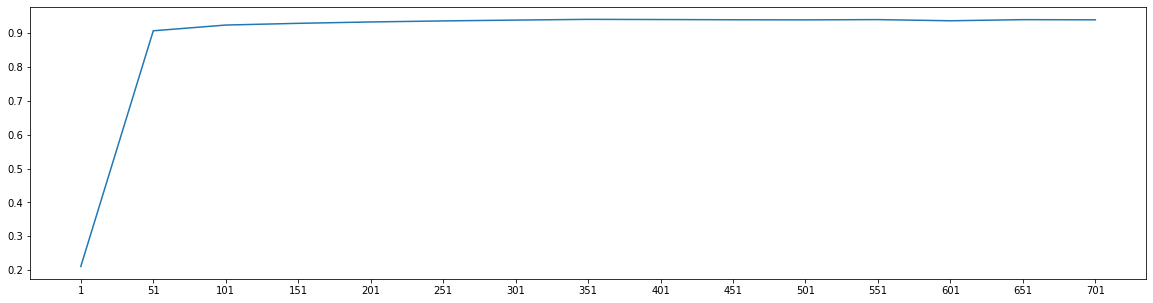

In [69]:
score = []
for i in range(1,751,50):
  X_wrapper = RFE(RFC_,n_features_to_select=i,step=50).fit_transform(X,y)
  once = cross_val_score(RFC_,X_wrapper,y,cv=5).mean()
  score.append(once)
plt.figure(figsize=[20,5])
plt.plot(range(1,751,50),score)
plt.xticks(range(1,751,50))

# 结果显示features选择50多准确率就能达到90